In [1]:
.libPaths(R.home('/opt/homebrew/Caskroom/miniforge/base/lib/R/library'))

In [2]:
if (!requireNamespace("BiocManager", quietly=TRUE)) 
    install.packages("BiocManager") 

BiocManager::install("mixOmics")
#BiocManager::install("BiocParallel")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.21 (BiocManager 1.30.26), R 4.5.1 (2025-06-13)

Installing package(s) 'mixOmics'

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'sf'



In [3]:
install.packages('plsdepot')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [4]:
Output = '/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1015. Fire Sufficient Similarity/P1015.3. Analyses/P1015.3.3. Cluster Analysis/Output'
cur_date = '080525'

library(readxl)
library(tidyverse)
library(reshape2)
# library(factoextra)
# library(FactoMineR)
# library(gridExtra)
library(ggrepel)
library(RColorBrewer)
library(gridtext)
library(plsdepot)

# reading in files
full_df = data.frame(read_excel("Input/Processed_Data_070825.xlsx")) %>%
    # creating sample ids
    unite("SampleID", c("HAWC_ID", "Sample_Number"), remove = FALSE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [5]:
head(full_df)

,Sample,SampleID,HAWC_ID,Study,Sample_Number,Class,Metric,DTXSID,Name,Value
,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,WF,1289909_1,1289909,Trieu et al. 2024,1,Metal,Volume,Cr,Chromium,NA
2,WF,1289909_1,1289909,Trieu et al. 2024,1,Metal,Volume,Cu,Copper,2.744161
3,WF,1289909_1,1289909,Trieu et al. 2024,1,Metal,Volume,Pb,Lead,2.584963
4,WF,1289909_1,1289909,Trieu et al. 2024,1,Metal,Volume,Ti,Titanium,5.087463
5,WF,1289909_1,1289909,Trieu et al. 2024,1,Metal,Volume,Zn,Zinc,4.523562
6,WF,1289909_1,1289909,Trieu et al. 2024,1,Metal,Volume,K,Potassium,NA


This analysis will use MCA to explore if chemical and metal concentrations of control, WS, and WF samples are similar.
https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=13cdfcda3ea8fe42bb6819f0f083a7878004004f

In [6]:
# will run MCA on each class, so the df will be split
split_df = full_df %>%
    # removing outliers
    group_by(Metric) %>%
    group_split

vol_df = split_df[[1]]
weight_df = split_df[[2]]

head(vol_df)

Sample,SampleID,HAWC_ID,Study,Sample_Number,Class,Metric,DTXSID,Name,Value
<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
WF,1289909_1,1289909,Trieu et al. 2024,1,Metal,Volume,Cr,Chromium,NA
WF,1289909_1,1289909,Trieu et al. 2024,1,Metal,Volume,Cu,Copper,2.744161
WF,1289909_1,1289909,Trieu et al. 2024,1,Metal,Volume,Pb,Lead,2.584963
WF,1289909_1,1289909,Trieu et al. 2024,1,Metal,Volume,Ti,Titanium,5.087463
WF,1289909_1,1289909,Trieu et al. 2024,1,Metal,Volume,Zn,Zinc,4.523562
WF,1289909_1,1289909,Trieu et al. 2024,1,Metal,Volume,K,Potassium,NA


In [7]:
`%notin%` <- Negate(`%in%`) 

wider_vol_df = vol_df %>%
    select(-c("Name", "Class")) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")

wider_weight_df = weight_df %>%
    select(-c("Name", "Class")) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")

head(wider_vol_df)

,Sample,HAWC_ID,Study,Sample_Number,Metric,Cr,Cu,Pb,Ti,Zn,K,Ca,Fe,Mn,Ni,Sr
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1289909_1,WF,1289909,Trieu et al. 2024,1,Volume,NA,2.744161,2.584963,5.087463,4.523562,NA,9.390169,8.233620,2.560715,1.000000,1.807355
885041_1,WS,885041,Ihantola et al. 2020,1,Volume,5.865424,9.820179,6.930737,4.940167,13.538795,16.91999,11.761136,10.561288,7.266787,4.822730,4.078951
885041_2,WS,885041,Ihantola et al. 2020,2,Volume,5.523562,8.640245,6.061776,5.281698,12.746304,16.19654,11.948002,9.383704,6.832890,4.655352,3.264536
993956_1,WS,993956,Ihantola et al. 2022,1,Volume,6.285402,7.577429,6.584963,4.954196,14.053332,15.87270,11.451726,10.452241,8.134426,5.584963,4.392317
1263480_1,WS,1263480,Burnet et al. 1990,1,Volume,NA,13.550867,12.425478,NA,18.116806,21.61807,18.892083,15.383671,13.550867,NA,12.773345
1263480_2,WS,1263480,Burnet et al. 1990,2,Volume,NA,13.340963,NA,11.358651,20.306748,20.07464,18.694559,14.587895,13.074476,10.426265,12.720886


In [9]:
nipals(wider_vol_df[,c(6:ncol(wider_vol_df))], comps = ncol(wider_vol_df) - 6)


NIPALS algorithm
----------------------------------
$values     eigenvalues
$scores     scores (T-components)
$loadings   loadings
$cor.xt     X,T correlations
$disto      distance to origin
$contrib    contribution of rows
$cos        squared cosinus
$dmod       distance to the model
----------------------------------


In [15]:
# do we not need to worry about scaling and centering data for mca?
# running MCA
vol_nipals = nipals(wider_vol_df[,c(6:ncol(wider_vol_df))], comps = ncol(wider_vol_df) - 5)
weight_nipals = nipals(wider_weight_df[,c(6:ncol(wider_weight_df))], comps = ncol(wider_weight_df) - 5)

# looking at a scree plot to see how much of the variance was captured in the first 2 eigenvectors
options(repr.plot.width = 10, repr.plot.height = 5) #changing size
# fviz_eig(vol_mca, addlabels = FALSE)
# fviz_eig(weight_mca, addlabels = FALSE)

In [17]:
vol_nipals$values
head(weight_nipals$values)

,values,percentage,cumulative
,<dbl>,<dbl>,<dbl>
v1,9.8378148,89.434680,89.43468
v2,0.8651872,7.865338,97.30002


,values,percentage,cumulative
,<dbl>,<dbl>,<dbl>
v1,12.3594962,58.854744,58.85474
v2,4.3926183,20.917230,79.77197
v3,1.9285739,9.183685,88.95566
v4,0.9110667,4.338413,93.29407
v5,1.0387621,4.946486,98.24056
v6,0.3862157,1.839122,100.07968


The first two components explain 97.3% of the variance of the volume data nd 79.8% for weight data. Not sure why it exceeds 100%?

In [33]:
# creating 1 df with eigenvectors and metadata
vol_nipals_df = data.frame(vol_nipals$scores[,1:2]) %>%
               rownames_to_column(var = "SampleID")
weight_nipals_df = data.frame(weight_nipals$scores[,1:2]) %>%
               rownames_to_column(var = "SampleID") 

more_data_df = rbind(wider_vol_df[,1:5] %>% 
                                    rownames_to_column(var = "SampleID"), 
                         wider_weight_df[,1:5] %>% 
                                    rownames_to_column(var = "SampleID")) 

full_eigenvector_df = inner_join(rbind(vol_nipals_df, weight_nipals_df), 
                                             more_data_df) %>%
    # cleaning variable names here
    mutate(Sample = ifelse(Sample == "WS", "Woodsmoke",
                                  ifelse(Sample == "WF", "Wildfire", Sample)))

head(full_eigenvector_df)

Joining with `by = join_by(SampleID)`


,SampleID,t1,t2,Sample,HAWC_ID,Study,Sample_Number,Metric
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>
1,1289909_1,-5.037056,-1.8306475,Wildfire,1289909,Trieu et al. 2024,1,Volume
2,885041_1,-1.764215,0.5471145,Woodsmoke,885041,Ihantola et al. 2020,1,Volume
3,885041_2,-2.305714,0.5891712,Woodsmoke,885041,Ihantola et al. 2020,2,Volume
4,993956_1,-1.859002,0.9265929,Woodsmoke,993956,Ihantola et al. 2022,1,Volume
5,1263480_1,3.309857,-0.3665063,Woodsmoke,1263480,Burnet et al. 1990,1,Volume
6,1263480_2,3.444141,0.3559708,Woodsmoke,1263480,Burnet et al. 1990,2,Volume


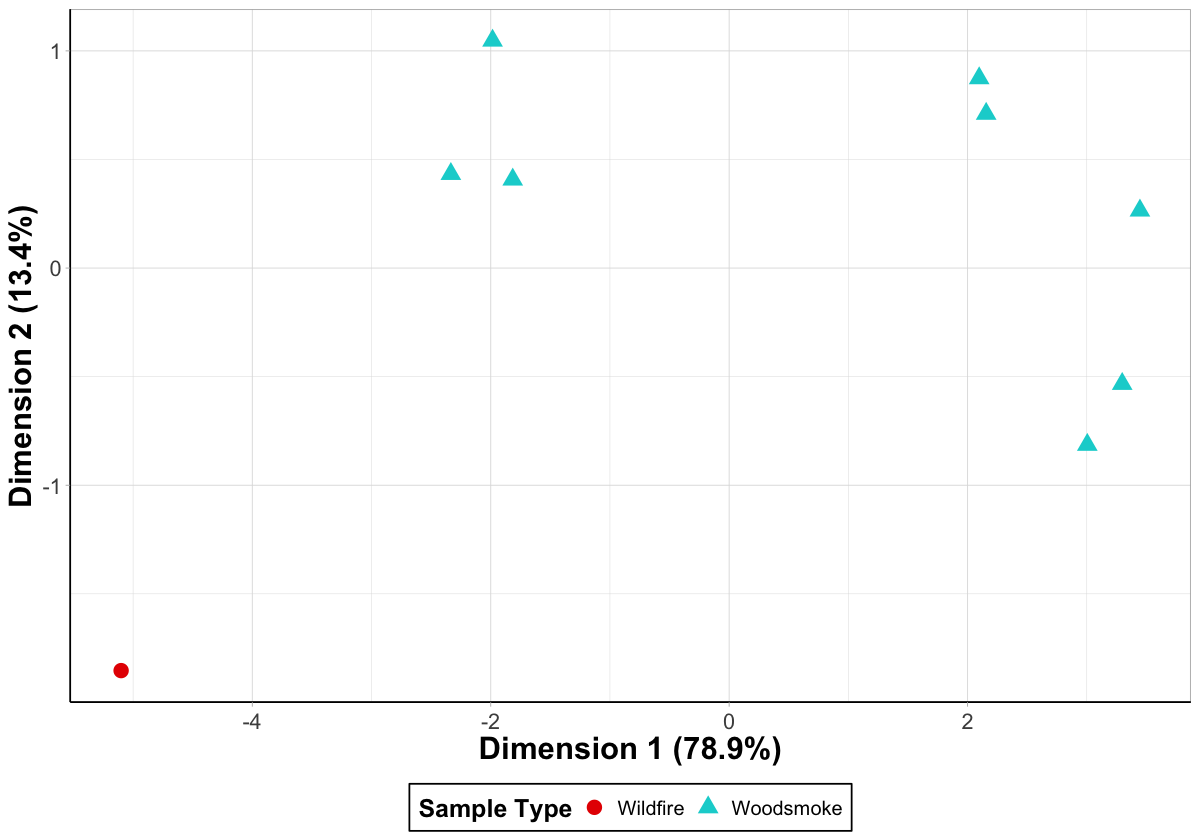

In [35]:
options(repr.plot.width=10, repr.plot.height=7) #changing size
vol_nipals_figure = ggplot() + 
  geom_point(data = full_eigenvector_df %>%
           filter(Metric == 'Volume'), aes(x = t1, y = t2, color = Sample, shape = Sample),
             size = 4, position = position_jitter(w = 0.2, h = 0.2), alpha = 1) + 
  # stat_ellipse(data = full_eigenvector_df %>%
  #          filter(Metric == 'Volume'), aes(x = t1, y = t2, color = Sample)) + 
  # geom_text_repel(data = full_eigenvector_df %>%
  #          filter(Metric == 'Volume', PC1 > 5), 
  #                 aes(x = PC1, y = PC2, color = Sample, label = SampleID), 
  #                 segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.3) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1 (78.9%)', y = 'Dimension 2 (13.4%)', #changing axis labels 
       color = "Sample Type", shape = "Sample Type") + #changing legend title

  scale_color_manual(values = c('#e60000', '#00d2d2'))

vol_nipals_figure

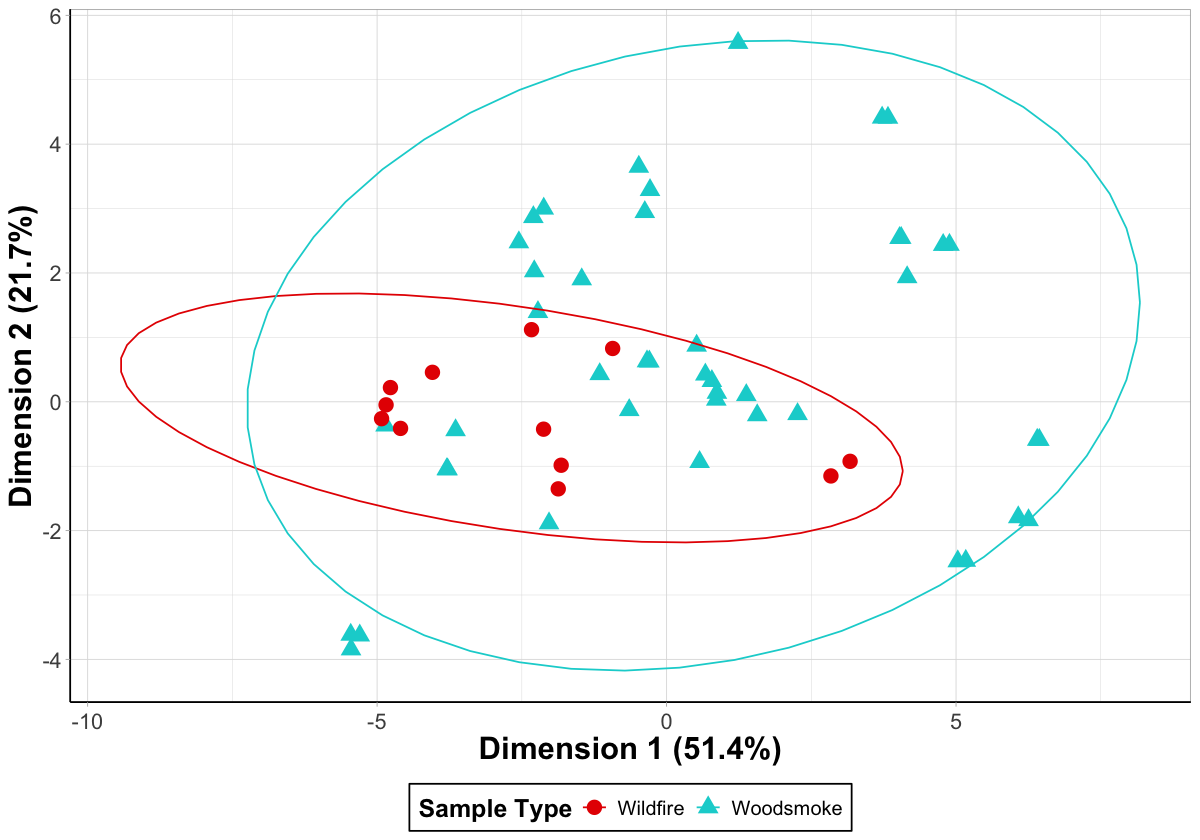

In [38]:
weight_nipals_figure = ggplot(data = full_eigenvector_df %>%
           filter(Metric == 'Weight'), 
       aes(x = t1, y = t2, color = Sample, shape = Sample)) + 
  geom_point(size = 4, position = position_jitter(w = 0.08)) + 
  stat_ellipse(data = full_eigenvector_df %>%
           filter(Metric == 'Weight'), aes(x = t1, y = t2, color = Sample)) + 
  # geom_text_repel(data = full_eigenvector_df %>%
  #          filter(Metric == 'Weight', PC1 < -10), 
  #                 aes(x = PC1, y = PC2, color = Sample, label = SampleID), 
  #                 segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.3) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1 (51.4%)', y = 'Dimension 2 (21.7%)', #changing axis labels 
       color = "Sample Type", shape = "Sample Type") + #changing legend title

  scale_color_manual(values = c('#e60000', '#00d2d2'))

weight_nipals_figure

In [39]:
vol_nipals$contrib
weight_nipals$contrib

,ctr.1,ctr.2
1289909_1,28.655787,43.038474
885041_1,3.515297,3.844181
885041_2,6.004401,4.457901
993956_1,3.903179,11.026187
1263480_1,12.373068,1.725085
1263480_2,13.397403,1.627332
1263480_3,5.158357,4.152528
1263484_2,4.975029,9.483492
1263484_1,10.906367,9.533710


,ctr.1,ctr.2,ctr.3,ctr.4,ctr.5,ctr.6,ctr.7,ctr.8,ctr.9,ctr.10,⋯,ctr.12,ctr.13,ctr.14,ctr.15,ctr.16,ctr.17,ctr.18,ctr.19,ctr.20,ctr.21
267105_1,0.701970401,1.467004e-02,0.007444014,8.0588999395,1.6771315071,6.515348e+00,0.609818935,3.147541e-02,1.252815514,2.810887881,⋯,3.514398e+01,2.079359e+00,0.429665160,4.500246e-01,0.273403403,0.44200460,5.122122e-01,0.400294043,6.176879e-01,0.593366422
267105_2,0.036582444,3.554015e-01,0.127348513,2.9245432381,0.1589787405,2.044034e+01,0.131035217,3.760403e+00,0.282593789,1.534526271,⋯,2.405848e+01,3.988771e+00,0.569621949,1.083954e+00,1.358300553,1.05869342,1.354561e+00,0.067188372,6.727937e-02,0.827795094
271638_1,3.749629680,2.475543e+00,0.632079302,4.9359116038,0.8424548720,4.259102e-01,0.406336902,6.361095e+00,5.076249534,0.565601696,⋯,8.401843e-03,8.747710e-01,1.169856530,5.540016e-01,0.585453795,1.48412988,2.863589e-02,1.537471366,7.989435e+00,0.512380541
271638_2,0.383951330,1.760247e-02,1.153769775,1.2137859461,0.0202674181,3.294271e+00,0.037717210,2.435335e+00,0.011972137,1.779780805,⋯,1.500005e-01,2.606615e+00,1.010238342,2.912459e+00,1.124674816,0.05967187,3.837104e+00,7.561645558,5.304483e+00,0.048932262
271638_3,5.526821718,1.371843e+00,0.643371815,0.4196201654,0.1130784870,5.033178e-01,0.057039388,2.034184e+00,1.562322889,1.465724575,⋯,6.163485e-01,1.562481e+00,0.209880308,9.134520e-02,0.001248941,0.44399652,7.181104e-01,0.263464763,5.174617e-01,0.592762698
271638_4,0.103298520,7.818567e-03,10.399202616,0.6617008133,0.2764889360,3.810002e-01,0.355773032,2.869277e-02,1.081363752,0.656571730,⋯,2.299397e-02,3.092778e-01,2.504213945,1.513215e-03,2.310542103,1.26073485,1.809996e-02,1.150289499,4.129251e-01,1.287716367
271638_5,0.060365144,7.310585e-02,3.123975725,2.4885288694,0.2484468848,1.187258e-01,0.005703971,1.435092e+00,1.082466034,1.489106097,⋯,1.983891e-05,7.665839e-02,1.661442884,1.529925e+00,0.453252787,4.05004001,1.000943e-01,0.057469822,4.101427e+00,0.241295633
271638_7,0.018041116,3.530234e+00,8.467204313,5.1681881387,1.1099167142,2.174871e+00,0.146991200,1.055025e-01,6.883365737,1.341699853,⋯,9.093763e-04,1.520813e+00,1.960026098,5.167081e+00,0.651986435,0.10426293,3.972857e+00,0.322570690,3.400440e+00,0.017141093
271638_6,0.701639274,7.891852e-01,1.572606812,2.9679667868,0.5889211463,1.005016e+00,0.073852751,5.091729e-03,13.180540983,0.204835733,⋯,6.539119e-01,2.775649e+00,0.029965963,1.033873e+00,3.118853121,5.93655304,5.680574e-01,0.011375626,3.719479e+00,1.030351958
271769_1,3.713388167,2.496983e+00,0.614638981,7.7549406956,0.0346571882,1.438249e-02,0.375583076,7.374055e+00,3.505702503,1.032766827,⋯,2.014691e-03,8.556356e-01,0.666668730,2.046511e+00,1.712853107,0.68145040,1.476914e+00,0.515374615,5.572310e+00,0.121075931
